In [1]:
# Importowanie bibliotek
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx

In [2]:
# Wczytanie danych
file_path = r'C:\XDDDD\AnomalyDetectionCityNetworks\dataset\Dataset.csv'
data = pd.read_csv(file_path)

In [3]:
# --------------------------------------------
# Sekcja 1: Clustering dla Sub Regions
# --------------------------------------------


In [4]:
# Wybor kolumn dla sub-regionow i danych binarnych
sub_region_col = 'sub-region'
binary_columns = data.select_dtypes(include=['int64']).columns
filtered_data = data[[sub_region_col] + list(binary_columns)]

In [5]:
# Mapowanie sub-regionow na wartosci numeryczne
sub_region_mapping = {region: idx for idx, region in enumerate(filtered_data[sub_region_col].unique())}
filtered_data.loc[:, 'sub-region'] = filtered_data['sub-region'].map(sub_region_mapping)


In [6]:
# Skalowanie danych dla sub-regionow
scaler = StandardScaler()
scaled_data_subregion = scaler.fit_transform(filtered_data)

In [7]:
# --------------------------------------------
# Sekcja 2: Clustering dla sieci (Network)
# --------------------------------------------

In [8]:
# Skalowanie danych sieciowych
network_data = data[binary_columns]
scaled_data_network = scaler.fit_transform(network_data)

In [9]:
# Optymalne parametry dla danych sieciowych
eps_network = 10
min_samples_network = 2

In [10]:
# Klasteryzacja DBSCAN dla danych sieciowych
dbscan_network = DBSCAN(eps=eps_network, min_samples=min_samples_network)
clusters_network = dbscan_network.fit_predict(scaled_data_network)

In [11]:
# Liczba klastrow i anomalii w danych sieciowych
num_clusters_network = len(set(clusters_network)) - (1 if -1 in clusters_network else 0)
num_anomalies_network = (clusters_network == -1).sum()

In [12]:
print(f"Liczba klastrow w danych sieciowych: {num_clusters_network}")
print(f"Liczba anomalii w danych sieciowych: {num_anomalies_network}")

Liczba klastrow w danych sieciowych: 77
Liczba anomalii w danych sieciowych: 311


In [13]:
# --------------------------------------------
# Sekcja 3: Clustering dla danych geograficznych z uwzględnieniem sub-regionów
# --------------------------------------------

In [14]:
# Kolumny geograficzne i sub-region
geo_columns = ['latitude', 'longitude']
sub_region_col = 'sub-region'

In [15]:
# Mapowanie sub-regionów na wartości numeryczne
sub_region_mapping = {region: idx for idx, region in enumerate(data[sub_region_col].unique())}
data['sub-region'] = data['sub-region'].map(sub_region_mapping)

In [16]:
# Połączenie danych geograficznych i sub-regionów
geo_data = data[geo_columns + ['sub-region']].dropna()

In [17]:
# Skalowanie danych geograficznych 
scaler = StandardScaler()
scaled_geo_data_with_subregion = scaler.fit_transform(geo_data)

In [18]:
# Parametry DBSCAN
eps_geo = 0.09
min_samples_geo = 7

In [19]:
# Klasteryzacja DBSCAN z uwzględnieniem sub-regionów
dbscan_geo_with_subregion = DBSCAN(eps=eps_geo, min_samples=min_samples_geo)
clusters_geo_with_subregion = dbscan_geo_with_subregion.fit_predict(scaled_geo_data_with_subregion)
geo_data['Cluster'] = clusters_geo_with_subregion

In [20]:
# Liczba klastrów i anomalii w danych geograficznych 
num_anomalies_geo_with_subregion = (geo_data['Cluster'] == -1).sum()
num_clusters_geo_with_subregion = geo_data['Cluster'].nunique() - (1 if -1 in geo_data['Cluster'].unique() else 0)

In [21]:
print(f"Liczba wykrytych anomalii w danych geograficznych : {num_anomalies_geo_with_subregion}")
print(f"Liczba wykrytych klastrów w danych geograficznych : {num_clusters_geo_with_subregion}")

Liczba wykrytych anomalii w danych geograficznych : 417
Liczba wykrytych klastrów w danych geograficznych : 53


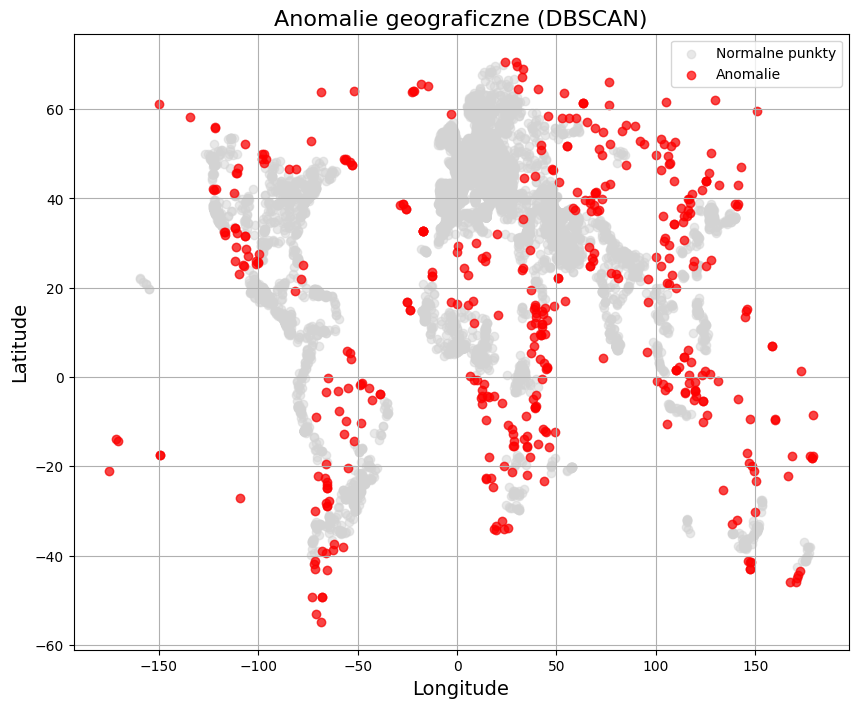

In [22]:
# Wizualizacja danych geograficznych 
plt.figure(figsize=(10, 8))
anomalies_geo = geo_data[geo_data['Cluster'] == -1]
plt.scatter(geo_data['longitude'], geo_data['latitude'], c='lightgray', alpha=0.5, label='Normalne punkty')
plt.scatter(anomalies_geo['longitude'], anomalies_geo['latitude'], c='red', label='Anomalie', alpha=0.7)
plt.title('Anomalie geograficzne (DBSCAN)', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1200x1000 with 0 Axes>

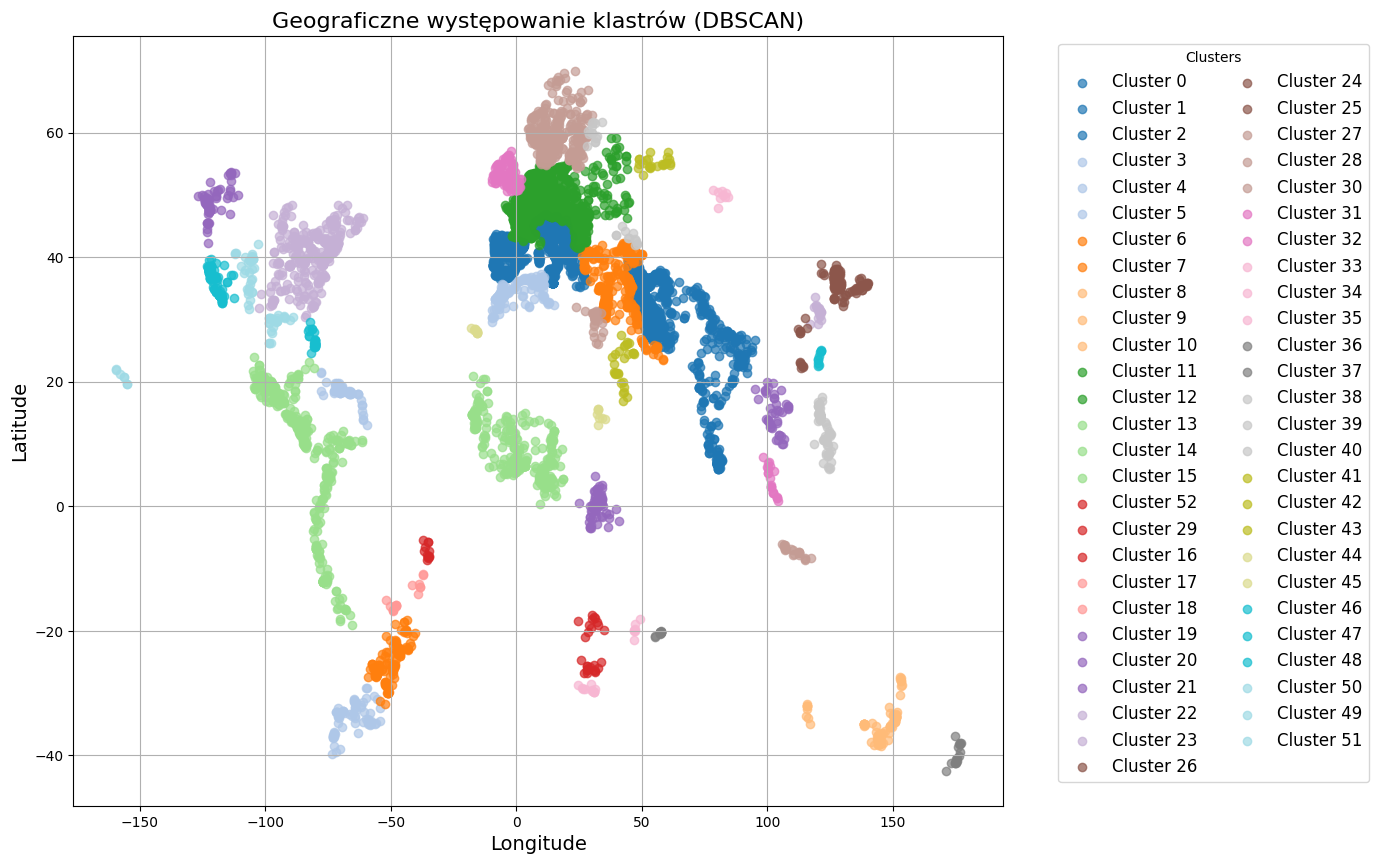

In [23]:
# Wizualizacja klastrów geograficznych 
plt.figure(figsize=(12, 10))
# Wizualizacja klastrów geograficznych 
plt.figure(figsize=(12, 10))
geo_data_no_anomalies = geo_data[geo_data['Cluster'] != -1]
unique_clusters_geo_with_subregion = geo_data_no_anomalies['Cluster'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters_geo_with_subregion)))
for cluster, color in zip(unique_clusters_geo_with_subregion, colors):
    cluster_points = geo_data_no_anomalies[geo_data_no_anomalies['Cluster'] == cluster][['longitude', 'latitude']].values
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        label=f'Cluster {cluster}',
        alpha=0.7,
        color=color
    )
    # Ustawienie legendy z podziałem na kolumny
plt.legend(
    title='Clusters',
    bbox_to_anchor=(1.05, 1),  # Pozycja legendy obok wykresu
    loc='upper left',
    fontsize=12,
    ncol=2  # Podział na dwie kolumny
)
plt.title('Geograficzne występowanie klastrów (DBSCAN)', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True)
plt.show()

Wyniki zostały zapisane do pliku: 'dbscan_results.csv'
Najbardziej optymalne parametry:
     eps  min_samples  num_clusters  num_anomalies  silhouette_score
31  42.0            2             3             19          0.830931


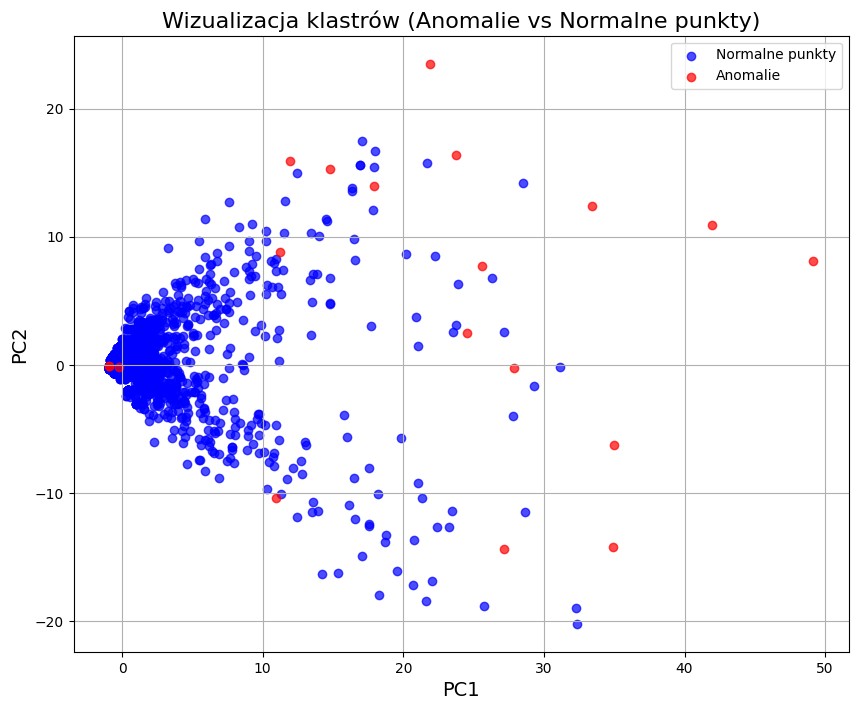

In [25]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Tworzenie siatki parametrów
param_grid = {
    'eps': np.arange(11, 100.0, 1),  # Zakres eps
    'min_samples': range(2, 3)     # Zakres min_samples
}

# Tworzenie obiektu ParameterGrid
grid = ParameterGrid(param_grid)

# Przechowywanie wyników
results = []

# Skalowanie danych (jeśli jeszcze nie zostało zrobione)
scaler = StandardScaler()
scaled_data_network = scaler.fit_transform(network_data)

# Iteracja po siatce parametrów
for params in grid:
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    clusters = dbscan.fit_predict(scaled_data_network)
    
    # Liczba klastrów
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    
    # Liczba anomalii
    num_anomalies = (clusters == -1).sum()
    
    # Obliczanie Silhouette Score (tylko gdy są co najmniej 2 klastry)
    if num_clusters > 1:
        silhouette_avg = silhouette_score(scaled_data_network, clusters)
    else:
        silhouette_avg = -1  # Brak sensownego wyniku
    
    
    # Zapis wyników
    results.append({
        'eps': params['eps'],
        'min_samples': params['min_samples'],
        'num_clusters': num_clusters,
        'num_anomalies': num_anomalies,
        'silhouette_score': silhouette_avg,
    })

# Tworzenie DataFrame z wynikami
results_df = pd.DataFrame(results)

# Zapis wyników do pliku CSV
results_df.to_csv('dbscan_results.csv', index=False)
print("Wyniki zostały zapisane do pliku: 'dbscan_results.csv'")

# Filtracja wyników według kryteriów optymalizacji
# Priorytet: maksymalny silhouette_score, minimalna liczba anomalii, minimalna liczba klastrów
optimal_results = results_df.sort_values(
    by=['silhouette_score', 'num_anomalies', 'num_clusters'], 
    ascending=[False, True, True]
).head(1)

# Wyświetlenie najlepszego zestawu parametrów
print("Najbardziej optymalne parametry:")
print(optimal_results)

# Zastosowanie optymalnych parametrów na danych sieciowych
optimal_eps = optimal_results.iloc[0]['eps']
optimal_min_samples = optimal_results.iloc[0]['min_samples']

dbscan_optimized = DBSCAN(eps=optimal_eps, min_samples=int(optimal_min_samples))
optimized_clusters = dbscan_optimized.fit_predict(scaled_data_network)

# Redukcja wymiarowości danych za pomocą PCA
pca_network = PCA(n_components=2)
reduced_data_network = pca_network.fit_transform(scaled_data_network)

# Podział danych na anomalie i normalne punkty
normal_points = reduced_data_network[optimized_clusters != -1]
anomalies = reduced_data_network[optimized_clusters == -1]

# Wizualizacja klastrów i anomalii
plt.figure(figsize=(10, 8))

# Wizualizacja normalnych punktów (klastry)
plt.scatter(normal_points[:, 0], normal_points[:, 1], 
            label='Normalne punkty', alpha=0.7, color='blue')

# Wizualizacja anomalii
plt.scatter(anomalies[:, 0], anomalies[:, 1], 
            label='Anomalie', alpha=0.7, color='red')

# Dodanie tytułów, etykiet i legendy
plt.title('Wizualizacja klastrów (Anomalie vs Normalne punkty)', fontsize=16)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)
plt.show()


In [28]:
for i in range (2,3):
    print(i)

2
